In [363]:
library(randomForest)
library(randomForestExplainer)
library(cluster)
library(boot)

# Unsupervised Random Forest :
## Test on dummy data
On va creer un jeu de donnée test, composé de 4 variables possédant une structure de dépendance et de N-4 variables constituées de bruit uniforme. Le but est de vérifier si la technique d'Unsupervised RF va différencier les variables importantes du bruit.

On va également effectuer une MDS a partir d'une matrice de proximité générée par la RF : comme les données seront en grande dimension, la distance euclidienne ne conviendra pas, en lieu de cela, la proximité sera définie par:

prox(obvservation i, observation j) = (#fois obj,obi € même feuille) / (#arbres)

In [364]:
###Création des variables dépendantes

nb_genes = 10
nb_cells = 50 

#Dépendances linéaires :
#X1 = runif(nb_cells) ; X2 = (X1 + runif(nb_cells)/4)/1.25 ; X3 = (X1 + runif(nb_cells))/2 ; X4 = (X3 + runif(nb_cells)/2)/1.5

#Dépendances polynomiales : 
#X1 = runif(nb_cells) ; X2 = X1^4  ; X3 = (X1^2 + X2^2)/2 ; X4 = X2^13

#Variables "clusterisées : 
#X1 = runif(nb_cells, 0, 0.25) ; X2 = runif(nb_cells, 0.25, 0.5) ; X3 = runif(nb_cells, 0.5, 0.75) ; X4 = runif(nb_cells, 0.75, 1)

#Dépendance + "clusterisées :
X1 = runif(nb_cells, 0, 0.25) ; X2 = X1 + 0.25 + runif(nb_cells, -0.05, 0.05) ; X3 = X1 + 0.5 + runif(nb_cells, -0.05, 0.05) ; X4 = X3 + 0.25 + runif(nb_cells, -0.05, 0.05)

#On créé une grande matrice d'expression de gènes
GeneExpr = data.frame(matrix(c(X1,X2, X3, X4), nb_cells, 4))
for (i in 1:(nb_genes-4)){
    GeneExpr[paste('Y', toString(i), sep='')] = runif(nb_cells)
}

#On remarque que les premières variables sont corrélées entre elles
cor(GeneExpr)[1:10,1:10]

,X1,X2,X3,X4,Y1,Y2,Y3,Y4,Y5,Y6
X1,1.00000000,0.92997118,0.913162196,0.78789529,-0.018571353,-0.27496943,-0.11642097,-0.190384147,0.05787837,-0.042697651
X2,0.92997118,1.00000000,0.824698443,0.72535338,-0.038507669,-0.35399688,-0.04615874,-0.102511379,0.06424761,-0.104877476
X3,0.91316220,0.82469844,1.000000000,0.91880534,-0.020219792,-0.19883471,-0.14926813,-0.142029395,0.11303557,0.007200767
X4,0.78789529,0.72535338,0.918805336,1.00000000,-0.060159133,-0.21480051,-0.14172138,-0.145958294,0.17113722,-0.065982050
Y1,-0.01857135,-0.03850767,-0.020219792,-0.06015913,1.000000000,-0.25524931,-0.03449364,0.004290984,0.08942823,0.310320713
Y2,-0.27496943,-0.35399688,-0.198834708,-0.21480051,-0.255249313,1.00000000,0.15665162,-0.074343986,-0.04442775,0.051071797
Y3,-0.11642097,-0.04615874,-0.149268128,-0.14172138,-0.034493638,0.15665162,1.00000000,0.073267957,0.09436524,0.179344158
Y4,-0.19038415,-0.10251138,-0.142029395,-0.14595829,0.004290984,-0.07434399,0.07326796,1.000000000,-0.05032162,0.184882250
Y5,0.05787837,0.06424761,0.113035567,0.17113722,0.089428230,-0.04442775,0.09436524,-0.050321624,1.00000000,-0.126472589
Y6,-0.04269765,-0.10487748,0.007200767,-0.06598205,0.310320713,0.05107180,0.17934416,0.184882250,-0.12647259,1.000000000


On crée un jeu de données synthétiques en effectuant un Bootstrap des observations de notre matrice d'expression de gêne. Ce jeu de données nous servira pour transformée le problème d'apprentissage non supervisé en problème supervisé.

In [365]:
synth_GeneExpr = GeneExpr
for (i in nb_genes){
    synth_GeneExpr[,i] = sample(GeneExpr[,i], replace = TRUE)
}

On crée deux classes arbitraires en rangeant nos données "réelles" dans l'une et nos données synthetiques dans l'autre. On va fit notre RF sur cette classification pour lui faire discerner les structures de dépendances entre les gènes.

In [366]:
synth_GeneExpr['Classe'] = vector('numeric', nb_cells) #Les données synthétiques dans la classe '0'
GeneExpr['Classe'] = vector('numeric', nb_cells)+1 #Les données synthétiques dans la classe '1'

train_GeneExpr = rbind(GeneExpr, synth_GeneExpr)
train_GeneExpr$Classe = factor(train_GeneExpr$Classe) #On change le type pour qu'il soit reconnu dans la RF en classification
#train_GeneExpr



<br><br><br><br>

# Random forest avec Addcl1 "homemade"

In [367]:
fit = randomForest(Classe~.-Classe,
                   data=train_GeneExpr,
                   mtry=as.integer(sqrt(nb_genes)),
                   ntree = 800,
                   proximity=TRUE, 
                   importance =TRUE
                   )


Call:
 randomForest(formula = Classe ~ . - Classe, data = train_GeneExpr,      mtry = as.integer(sqrt(nb_genes)), ntree = 800, proximity = TRUE,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 800
No. of variables tried at each split: 3

        OOB estimate of  error rate: 99%
Confusion matrix:
   0  1 class.error
0  1 49        0.98
1 50  0        1.00

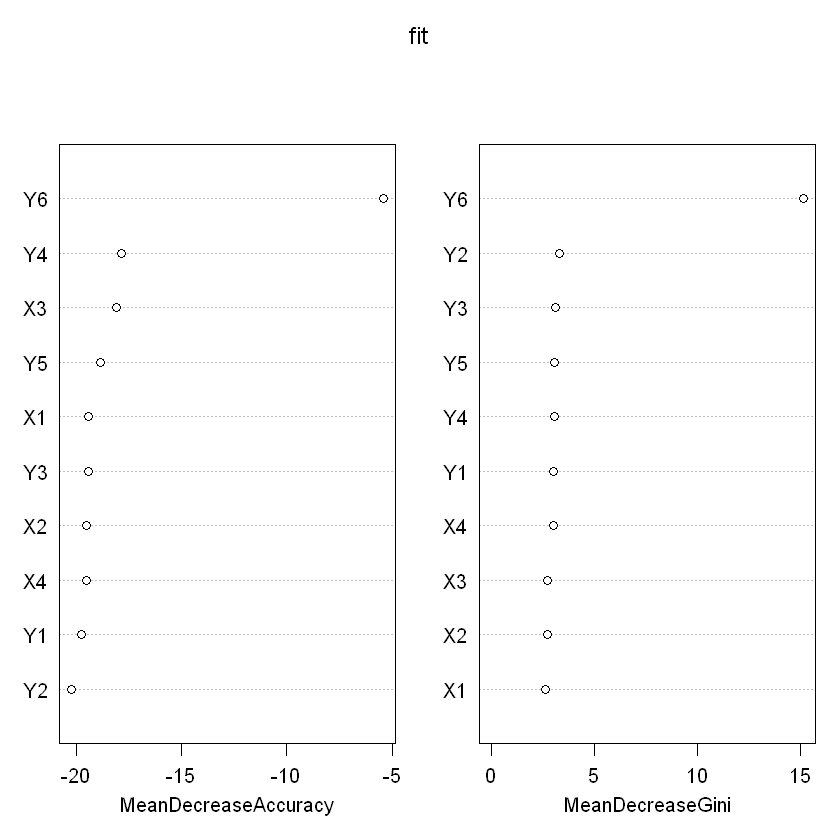

In [368]:
fit
varImpPlot(fit)

<br><br><br><br>
## On réessaie en utilisant la fonction de sampling Addcl1 de Briemann

In [369]:
GeneExpr$Classe = NULL
fit2 = randomForest(GeneExpr[-205], addclass = 1, importance = TRUE, proximity = TRUE)


Call:
 randomForest(x = GeneExpr[-205], importance = TRUE, proximity = TRUE,      addclass = 1) 
               Type of random forest: unsupervised
                     Number of trees: 500
No. of variables tried at each split: 3


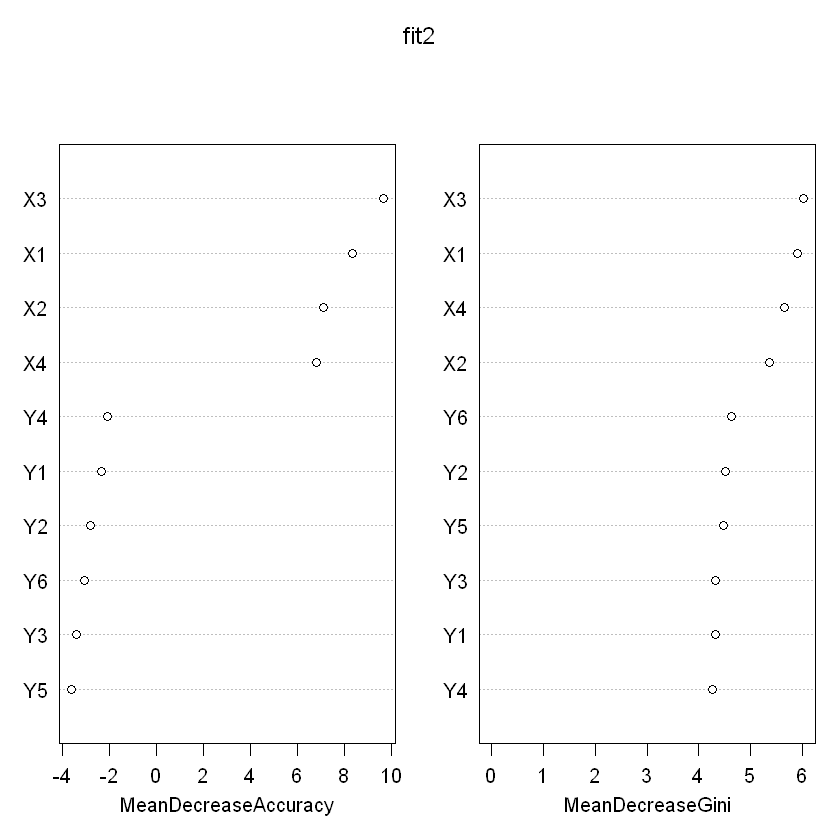

In [370]:
fit2
varImpPlot(fit2)

## MDS

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

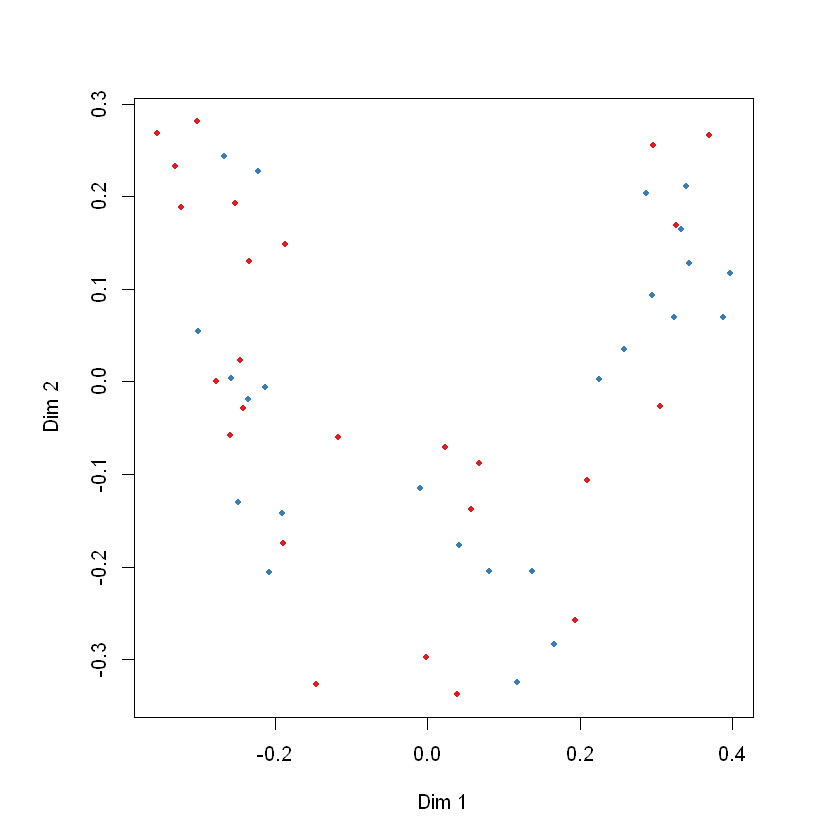

In [371]:
MDSplot(fit2, fit2$classes)